In [1]:
import numpy as np

In [1]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20,20]


def fix_scaling(ax=None):
    if not ax:
        xlim = plt.xlim()
        ylim = plt.ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            plt.ylim((ylim[0] - (d1-d2) / 2, ylim[1] + (d1-d2) / 2))
        else:
            plt.xlim((xlim[0] + (d1-d2) / 2, xlim[1] - (d1-d2) / 2))
    else:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        d1 = xlim[1] - xlim[0]
        d2 = ylim[1] - ylim[0]
        if d1 > d2:
            ax.set_ylim((ylim[0] - (d1-d2) / 2, ylim[1] + (d1-d2) / 2))
        else:
            ax.set_xlim((xlim[0] + (d1-d2) / 2, xlim[1] - (d1-d2) / 2))

In [3]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def animate_trajectory(trajectories, n, f, x_min):
    fig, ax = plt.subplots()
    colors = ['blue', 'orange', 'green', 'red']
    
    def step(t):
        ax.cla()
        ax.plot([x_min[0]], [x_min[1]], 'o', color='green')
        # Level contours
        delta = 0.025
        x = np.arange(-3, 3, delta)
        y = np.arange(-3, 3, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.zeros_like(X)
        # print(X.shape, Y.shape)
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z[i][j] = f([X[i][j], Y[i][j]])
        CS = ax.contour(X, Y, Z, [0.5, 3, 7.5], colors=['blue', 'purple', 'red'])

        for traj, color in zip(trajectories, colors):
            ax.plot([u[0] for u in traj[0][:t]], [u[1] for u in traj[0][:t]], color=color)
            ax.plot([u[0] for u in traj[0][:t]], [u[1] for u in traj[0][:t]], 'o', color=color)

        fix_scaling(ax)
        ax.axis('off')

    plt.close()
    return FuncAnimation(fig, step, frames=range(n), interval=600)

In [ ]:
NUMBER_OF_STEPS = 30

In [5]:
def f(x):
    return 3 * x[0] ** 2 + 22 * (x[0] - x[1]) ** 2 - x[0] - 2 * x[1]


def f_grad(x):
    return np.array([50 * x[0] - 44 * x[1] - 1,
                     - 44 * x[0] + 44 * x[1] - 2])


def f_hessian():
    return np.array([[50, -44],
                     [-44, 44]])


def hessian_eigen_values():
    return list(np.linalg.eig(f_hessian()))[0]

In [6]:
def optimal_step(x_start):
    alpha = 2.0 / sum(hessian_eigen_values())
    traj_opt_step = [x_start.copy()]
    cur_x = x_start.copy()
    for i in range(NUMBER_OF_STEPS):
        cur_x = cur_x - alpha * f_grad(cur_x)
        traj_opt_step.append(cur_x.copy())

    print(traj_opt_step[-1])
    return [traj_opt_step, 'Optimal step']

In [7]:
def heavy_ball(x_start):
    lambdas = hessian_eigen_values()
    alpha = 4.0 / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1])) ** 2
    beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
    traj_heavy_ball = [x_start.copy()]
    cur_x = x_start.copy()
    prev_x = x_start.copy()
    for i in range(NUMBER_OF_STEPS):
        t = cur_x
        cur_x = cur_x - alpha * f_grad(cur_x) + beta * (cur_x - prev_x)
        prev_x = t
        traj_heavy_ball.append(cur_x.copy())

    print(traj_heavy_ball[-1])
    return [traj_heavy_ball, 'Heavy ball']

In [10]:
def chebyshev(x_start):
    lambdas = hessian_eigen_values()
    phi = (lambdas[0] + lambdas[1]) / (lambdas[0] - lambdas[1])
    cur_gamma = 1.0 / phi
    prev_gamma = 0
    traj_chebyshev = [x_start.copy()]
    cur_x = x_start.copy()
    prev_x = x_start.copy()
    for i in range(NUMBER_OF_STEPS):
        t = cur_x
        alpha = 4 * cur_gamma / (lambdas[0] - lambdas[1])
        beta = cur_gamma * prev_gamma
        cur_x = cur_x - alpha * f_grad(cur_x) + beta * (cur_x - prev_x)
        prev_x = t
        t = cur_gamma
        cur_gamma = 1.0 / (2 * phi - cur_gamma)
        prev_gamma = t
        traj_chebyshev.append(cur_x.copy())

    print(traj_chebyshev[-1])
    return [traj_chebyshev, 'Chebyshev']

In [8]:
def nesterov(x_start):
    lambdas = hessian_eigen_values()
    alpha = 1 / (lambdas[0] + 1)
    beta = (np.sqrt(lambdas[0]) - np.sqrt(lambdas[1])) / (np.sqrt(lambdas[0]) + np.sqrt(lambdas[1]))
    traj_nesterov = [x_start.copy()]
    cur_x = x_start.copy()
    cur_y = x_start.copy()

    for i in range(NUMBER_OF_STEPS):
        t = cur_x
        cur_x = cur_y - alpha * f_grad(cur_y)
        cur_y = cur_x + beta * (cur_x - t)
        traj_nesterov.append(cur_x.copy())

    print(traj_nesterov[-1])
    return [traj_nesterov, 'Nesterov']

In [ ]:
def solve_equation():
    zeros = np.zeros(2)
    x_min = np.linalg.solve(f_hessian(), -f_grad(zeros))
    print(x_min)
    print(f(x_min))
    return x_min, f(x_min)

In [11]:
def argument_distance_plot(trajectories, x_min):
    fig, ax = plt.subplots()
    for traj in trajectories:
        ax.plot(range(NUMBER_OF_STEPS + 1), [np.linalg.norm(x - x_min) for x in traj[0]], label=traj[1])
    plt.legend()
    plt.plot()
    plt.show()

In [12]:
def function_distance_plot(trajectories, f_min):
    fig, ax = plt.subplots()
    for traj in trajectories:
        ax.plot(range(NUMBER_OF_STEPS + 1), [f(x) - f_min for x in traj[0]], label=traj[1])
    plt.legend()
    plt.plot()
    plt.show()

In [17]:
x_start = np.array([2, 2.8])
trajectories = []
trajectories.append(optimal_step(x_start))
trajectories.append(heavy_ball(x_start))
trajectories.append(chebyshev(x_start))
trajectories.append(nesterov(x_start))
x_min, f_min = solve_equation()

[ 0.72230519  0.87958599]
[ 0.50258616  0.54168839]
[ 0.4991112   0.54614235]
[ 0.53442048  0.58230179]
[ 0.5         0.54545455]
-0.795454545455


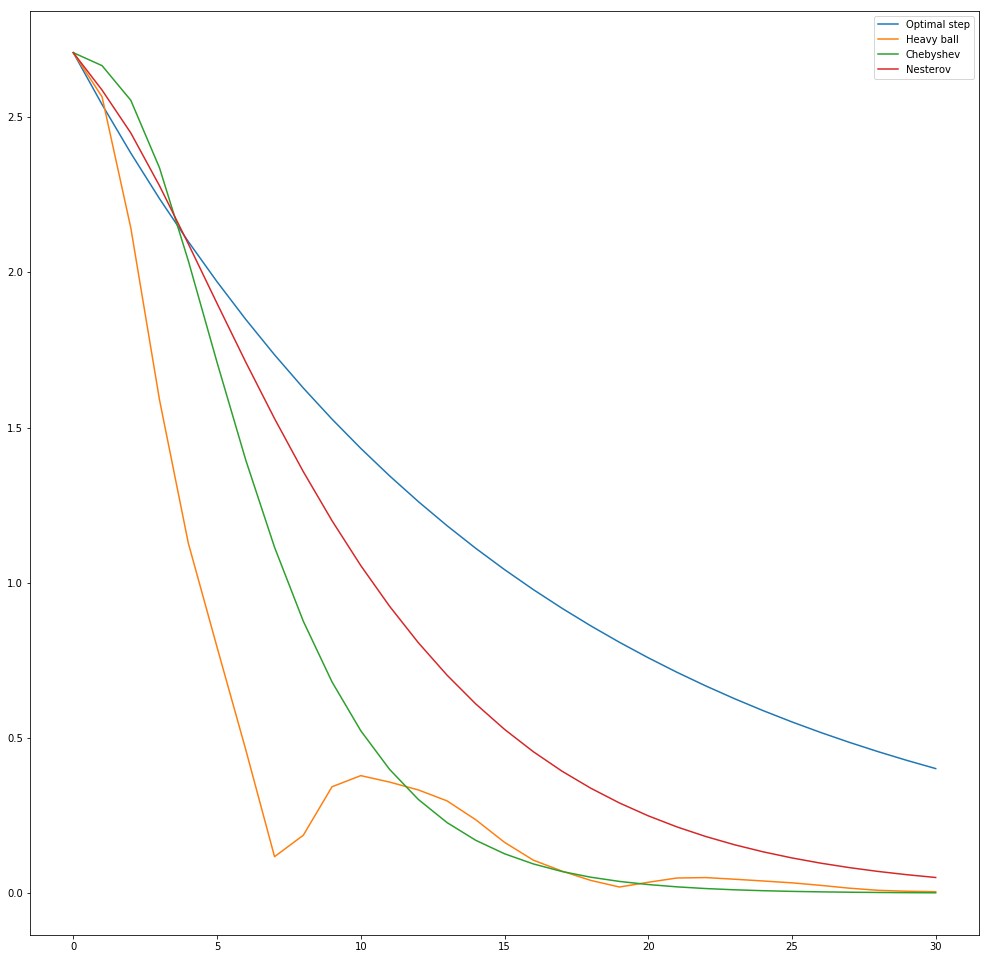

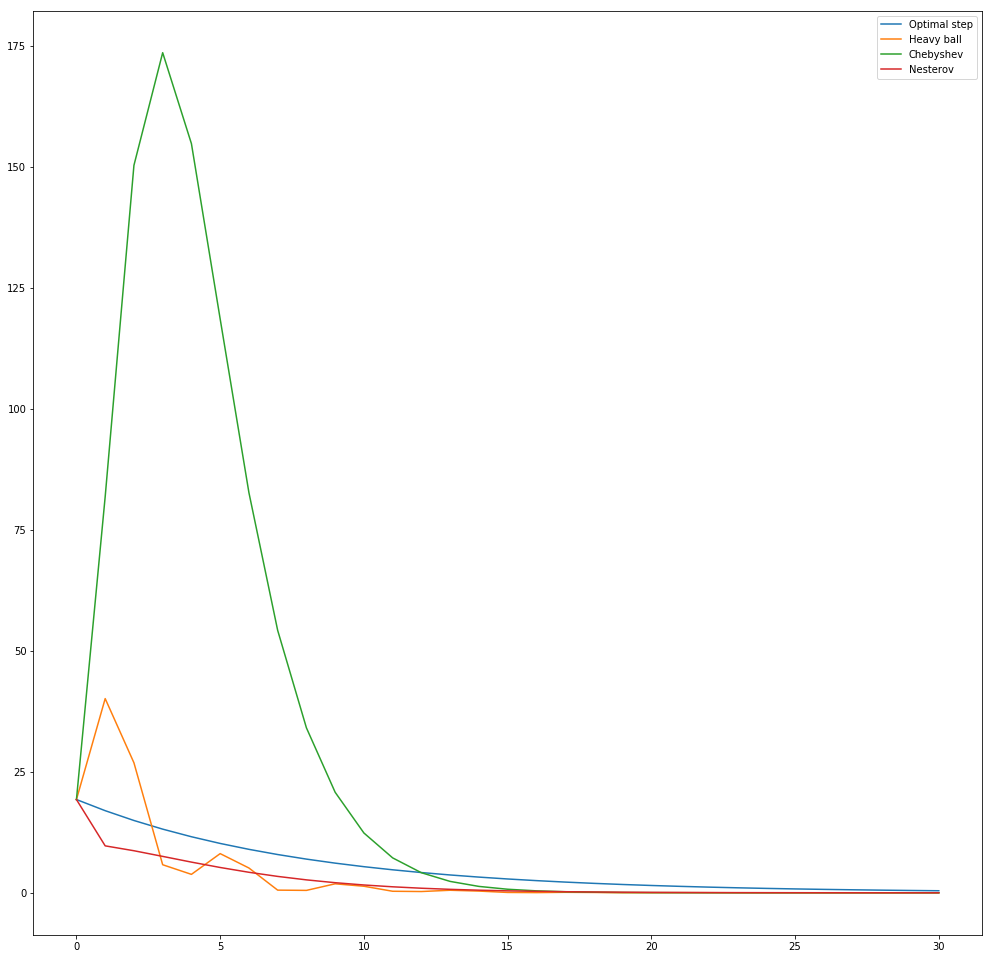

In [18]:
argument_distance_plot(trajectories, x_min)
function_distance_plot(trajectories, f_min)

In [19]:
base_animation = animate_trajectory(trajectories, NUMBER_OF_STEPS, f, x_min)
HTML(base_animation.to_html5_video())